In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
import io, pandas as pd

In [ ]:
df = pd.read_csv('job_dataset.csv')

In [ ]:
df.head(5)

,JobID,Title,ExperienceLevel,YearsOfExperience,Skills,Responsibilities,Keywords
0,NET-F-001,.NET Developer,Fresher,0-1,C#; VB.NET basics; .NET Framework; .NET Core f...,Assist in coding and debugging applications; L...,.NET; C#; ASP.NET MVC; Entity Framework; SQL S...
1,NET-F-002,.NET Developer,Fresher,0-1,C#; .NET Framework basics; ASP.NET; Razor; HTM...,Write simple C# programs under guidance; Suppo...,.NET; C#; ASP.NET MVC; Entity Framework; SQL S...
2,NET-F-003,.NET Developer,Fresher,0-1,C#; VB.NET basics; .NET Core; ASP.NET MVC; HTM...,Contribute to development of small modules; As...,.NET; C#; ASP.NET MVC; SQL Server; Entity Fram...
3,NET-F-004,.NET Developer,Fresher,0-1,C#; .NET Framework; ASP.NET basics; SQL Server...,Support in software design documentation; Assi...,.NET; C#; SQL Server; Entity Framework; ASP.NET
4,NET-F-005,.NET Developer,Fresher,0-1,C#; ASP.NET; MVC; Entity Framework basics; SQL...,Learn to design and build ASP.NET applications...,.NET; C#; ASP.NET MVC; Entity Framework; SQL S...


In [ ]:
print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nSample value counts for ExperienceLevel:")
print(df['ExperienceLevel'].value_counts().head(20))

Columns: ['JobID', 'Title', 'ExperienceLevel', 'YearsOfExperience', 'Skills', 'Responsibilities', 'Keywords']

Missing values per column:
 JobID                0
Title                1
ExperienceLevel      0
YearsOfExperience    0
Skills               0
Responsibilities     0
Keywords             0
dtype: int64

Data types:
 JobID                object
Title                object
ExperienceLevel      object
YearsOfExperience    object
Skills               object
Responsibilities     object
Keywords             object
dtype: object

Sample value counts for ExperienceLevel:
ExperienceLevel
Experienced         476
Fresher             363
Entry-Level          66
Senior-Level         66
Mid-Level            60
Senior               15
Lead                  7
Junior                5
Mid-level             5
Mid-Senior Level      3
Mid-Senior            2
Name: count, dtype: int64


In [ ]:
text_cols = ['Title', 'Skills', 'Responsibilities', 'Keywords']
for c in text_cols:
    if c not in df.columns:
        print("Warning: expected column", c, "not found.")
        df[c] = ''

In [ ]:
df[text_cols] = df[text_cols].fillna('')

In [ ]:
df['text'] = (df['Title'].astype(str) + ' ' +
              df['Skills'].astype(str) + ' ' +
              df['Responsibilities'].astype(str) + ' ' +
              df['Keywords'].astype(str)).str.replace(r'\s+', ' ', regex=True)

In [ ]:
df[['Title','Skills','text']].head(3)

,Title,Skills,text
0,.NET Developer,C#; VB.NET basics; .NET Framework; .NET Core f...,.NET Developer C#; VB.NET basics; .NET Framewo...
1,.NET Developer,C#; .NET Framework basics; ASP.NET; Razor; HTM...,.NET Developer C#; .NET Framework basics; ASP....
2,.NET Developer,C#; VB.NET basics; .NET Core; ASP.NET MVC; HTM...,.NET Developer C#; VB.NET basics; .NET Core; A...


In [ ]:
import re

In [ ]:
def map_explevel(s):
    s = str(s).lower()
    if any(x in s for x in ['fresher', 'intern', 'trainee']):
        return 'Fresher'
    if any(x in s for x in ['entry', 'junior', 'associate', 'entry-level']):
        return 'Entry'
    if any(x in s for x in ['mid', 'mid-senior', 'mid level', 'mid-senior level']):
        return 'Mid'
    if any(x in s for x in ['senior', 'lead', 'principal', 'manager', 'experienced', 'senior-level']):
        return 'Senior'

    nums = re.findall(r'\d+(?:\.\d+)?', s)
    if nums:
        nums = [float(n) for n in nums]
        avg = sum(nums)/len(nums)
        if avg <= 1: return 'Fresher'
        if avg <= 3: return 'Entry'
        if avg <= 6: return 'Mid'
        return 'Senior'

    return 'Other'


In [ ]:
df['label'] = df['ExperienceLevel'].apply(map_explevel)
print("Label counts:\n", df['label'].value_counts())

print("Rows with label 'Other':", (df['label']=='Other').sum())
df = df[df['label'] != 'Other'].copy()

Label counts:
 label
Senior     564
Fresher    363
Entry       71
Mid         70
Name: count, dtype: int64
Rows with label 'Other': 0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_text = tfidf.fit_transform(df['text'])

# Create 'years_num' column by extracting numerical values from 'YearsOfExperience'
df['years_num'] = df['YearsOfExperience'].str.extract(r'(\d+)').astype(float)

scaler = StandardScaler()
years_scaled = scaler.fit_transform(df[['years_num']].astype(float))
years_sparse = csr_matrix(years_scaled)  # convert to sparse to hstack

X = hstack([X_text, years_sparse])
print("Feature matrix shape:", X.shape)

Feature matrix shape: (1068, 5001)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['label'])
print("Classes:", le.classes_)

Classes: ['Entry' 'Fresher' 'Mid' 'Senior']


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

models = {
    'DecisionTree': DecisionTreeClassifier(max_depth=20, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
}

def eval_on_split(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'report': classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0),
        'confusion': confusion_matrix(y_test, y_pred)
    }

In [ ]:
from sklearn.model_selection import train_test_split

results = []
for test_size, split_name in [(0.30, '70/30'), (0.20, '80/20')]:
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    for name, model in models.items():
        stats = eval_on_split(model, X_tr, X_te, y_tr, y_te)
        results.append({
            'model': name,
            'split': split_name,
            'accuracy': stats['accuracy'],
            'precision_macro': stats['precision_macro'],
            'recall_macro': stats['recall_macro'],
            'f1_macro': stats['f1_macro']
        })
        print(f"\n{name} on {split_name}: acc={stats['accuracy']:.4f}, f1_macro={stats['f1_macro']:.4f}")
        print("Classification report:\n", stats['report'])


DecisionTree on 70/30: acc=0.9346, f1_macro=0.8711
Classification report:
               precision    recall  f1-score   support

       Entry       0.83      0.95      0.89        21
     Fresher       0.99      0.96      0.98       109
         Mid       0.59      0.76      0.67        21
      Senior       0.97      0.94      0.95       170

    accuracy                           0.93       321
   macro avg       0.85      0.90      0.87       321
weighted avg       0.94      0.93      0.94       321


RandomForest on 70/30: acc=0.9813, f1_macro=0.9560
Classification report:
               precision    recall  f1-score   support

       Entry       1.00      0.86      0.92        21
     Fresher       0.97      1.00      0.99       109
         Mid       1.00      0.86      0.92        21
      Senior       0.98      1.00      0.99       170

    accuracy                           0.98       321
   macro avg       0.99      0.93      0.96       321
weighted avg       0.98      0.98

In [ ]:
from sklearn.model_selection import cross_validate, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for model_name, model in models.items():
    cv_res = cross_validate(model, X, y, cv=skf, scoring=scoring, n_jobs=-1)
    print(f"{model_name} 5-fold CV:")
    print(f"  Accuracy mean = {cv_res['test_accuracy'].mean():.4f}")
    print(f"  Precision mean = {cv_res['test_precision_macro'].mean():.4f}")
    print(f"  Recall mean = {cv_res['test_recall_macro'].mean():.4f}")
    print(f"  F1 mean = {cv_res['test_f1_macro'].mean():.4f}\n")

DecisionTree 5-fold CV:
  Accuracy mean = 0.9616
  Precision mean = 0.9107
  Recall mean = 0.9394
  F1 mean = 0.9228

RandomForest 5-fold CV:
  Accuracy mean = 0.9831
  Precision mean = 0.9881
  Recall mean = 0.9388
  F1 mean = 0.9596

KNN 5-fold CV:
  Accuracy mean = 0.9841
  Precision mean = 0.9651
  Recall mean = 0.9660
  F1 mean = 0.9634



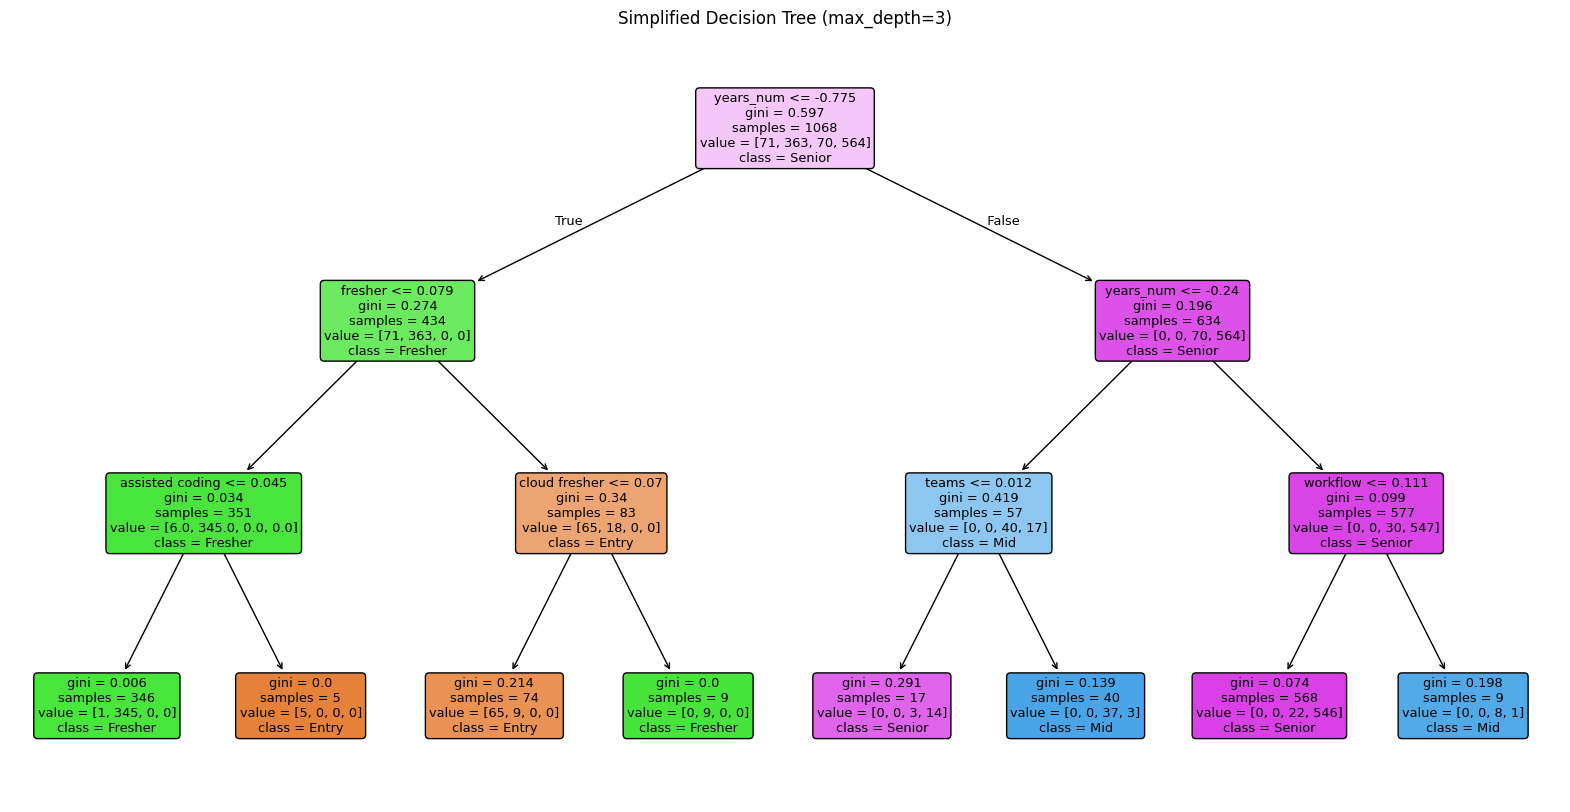

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import re

# Load the dataframe
df = pd.read_csv('job_dataset.csv')

# Re-create X and y
text_cols = ['Title', 'Skills', 'Responsibilities', 'Keywords']
for c in text_cols:
    if c not in df.columns:
        df[c] = ''
df[text_cols] = df[text_cols].fillna('')
df['text'] = (df['Title'].astype(str) + ' ' +
              df['Skills'].astype(str) + ' ' +
              df['Responsibilities'].astype(str) + ' ' +
              df['Keywords'].astype(str)).str.replace(r'\s+', ' ', regex=True)

# Re-create tfidf and X
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_text = tfidf.fit_transform(df['text'])
df['years_num'] = df['YearsOfExperience'].astype(str).str.extract(r'(\d+)').astype(float)
scaler = StandardScaler()
years_scaled = scaler.fit_transform(df[['years_num']].astype(float))
years_sparse = csr_matrix(years_scaled)
X = hstack([X_text, years_sparse])

# Re-create y and class_names
def map_explevel(s):
    s = str(s).lower()
    if any(x in s for x in ['fresher', 'intern', 'trainee']):
        return 'Fresher'
    if any(x in s for x in ['entry', 'junior', 'associate', 'entry-level']):
        return 'Entry'
    if any(x in s for x in ['mid', 'mid-senior', 'mid level', 'mid-senior level']):
        return 'Mid'
    if any(x in s for x in ['senior', 'lead', 'principal', 'manager', 'experienced', 'senior-level']):
        return 'Senior'
    nums = re.findall(r'\d+(?:\.\d+)?', s)
    if nums:
        nums = [float(n) for n in nums]
        avg = sum(nums)/len(nums)
        if avg <= 1: return 'Fresher'
        if avg <= 3: return 'Entry'
        if avg <= 6: return 'Mid'
        return 'Senior'
    return 'Other'

df['label'] = df['ExperienceLevel'].apply(map_explevel)
df = df[df['label'] != 'Other'].copy()

le = LabelEncoder()
y = le.fit_transform(df['label'])
class_names = le.classes_

# Train a smaller Decision Tree model
# Limiting max_depth to make the tree visualization manageable
small_dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
small_dt_model.fit(X, y)

# Get feature names
feature_names = tfidf.get_feature_names_out().tolist() + ['years_num']

# Visualize the smaller Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(small_dt_model, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
plt.title("Simplified Decision Tree (max_depth=3)")
plt.show()

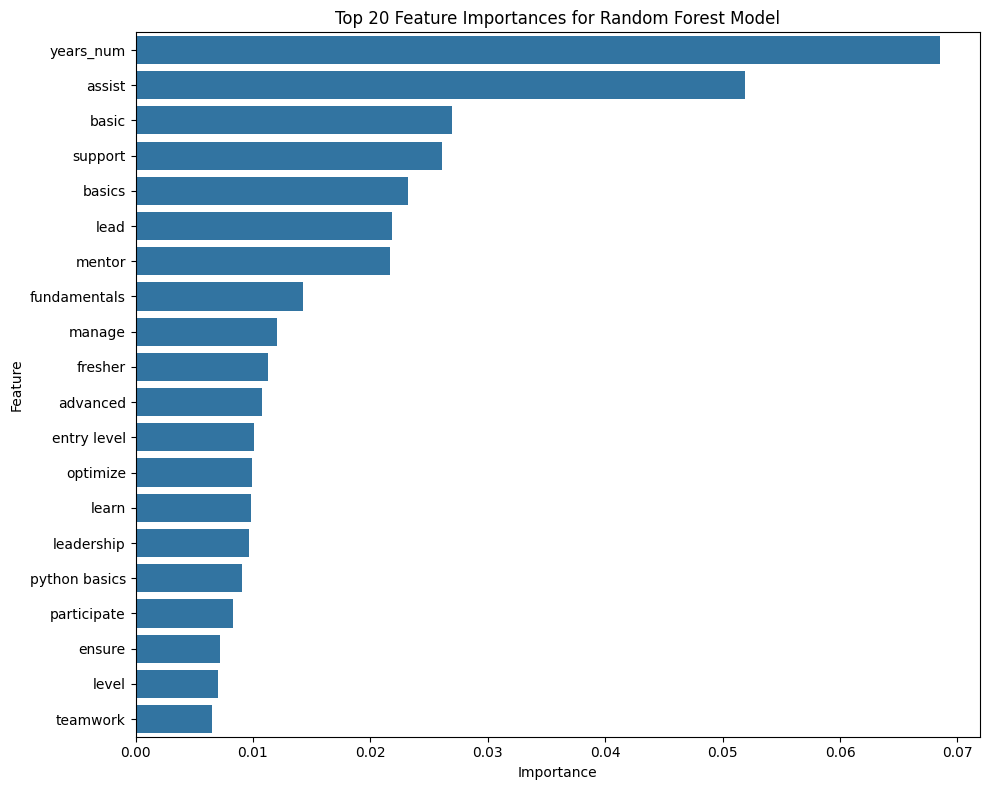

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import re

# Load the dataframe
df = pd.read_csv('job_dataset.csv')

# Re-create X and y
text_cols = ['Title', 'Skills', 'Responsibilities', 'Keywords']
for c in text_cols:
    if c not in df.columns:
        df[c] = ''
df[text_cols] = df[text_cols].fillna('')
df['text'] = (df['Title'].astype(str) + ' ' +
              df['Skills'].astype(str) + ' ' +
              df['Responsibilities'].astype(str) + ' ' +
              df['Keywords'].astype(str)).str.replace(r'\s+', ' ', regex=True)

# Re-create tfidf and X
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_text = tfidf.fit_transform(df['text'])
df['years_num'] = df['YearsOfExperience'].astype(str).str.extract(r'(\d+)').astype(float)
scaler = StandardScaler()
years_scaled = scaler.fit_transform(df[['years_num']].astype(float))
years_sparse = csr_matrix(years_scaled)
X = hstack([X_text, years_sparse])

# Re-create y and class_names
def map_explevel(s):
    s = str(s).lower()
    if any(x in s for x in ['fresher', 'intern', 'trainee']):
        return 'Fresher'
    if any(x in s for x in ['entry', 'junior', 'associate', 'entry-level']):
        return 'Entry'
    if any(x in s for x in ['mid', 'mid-senior', 'mid level', 'mid-senior level']):
        return 'Mid'
    if any(x in s for x in ['senior', 'lead', 'principal', 'manager', 'experienced', 'senior-level']):
        return 'Senior'
    nums = re.findall(r'\d+(?:\.\d+)?', s)
    if nums:
        nums = [float(n) for n in nums]
        avg = sum(nums)/len(nums)
        if avg <= 1: return 'Fresher'
        if avg <= 3: return 'Entry'
        if avg <= 6: return 'Mid'
        return 'Senior'
    return 'Other'

df['label'] = df['ExperienceLevel'].apply(map_explevel)
df = df[df['label'] != 'Other'].copy()

le = LabelEncoder()
y = le.fit_transform(df['label'])
class_names = le.classes_

# Train the Random Forest model (using the same parameters as in cell W28jvUdJ6BkV)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names
feature_names = tfidf.get_feature_names_out().tolist() + ['years_num']

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort by importance and take the top N features
top_n = 20  # You can adjust this number
top_features = importance_df.sort_values(by='importance', ascending=False).head(top_n)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title(f'Top {top_n} Feature Importances for Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

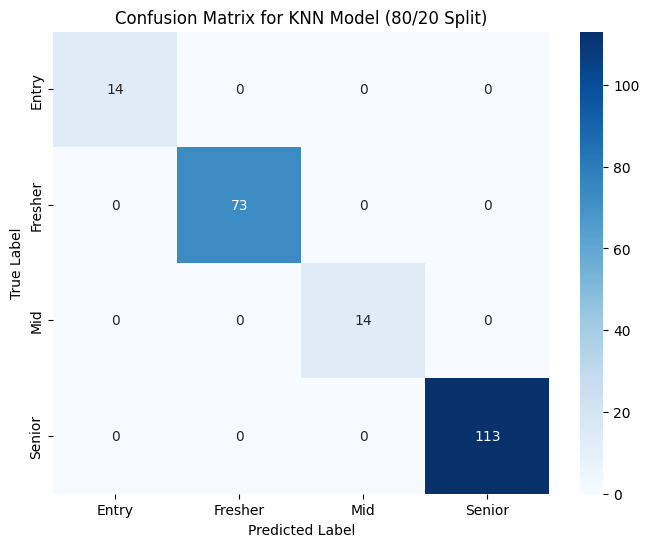

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier # Import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report # Import necessary metrics
import pandas as pd
import re

# Load the dataframe
df = pd.read_csv('job_dataset.csv')

# Re-create X and y
text_cols = ['Title', 'Skills', 'Responsibilities', 'Keywords']
for c in text_cols:
    if c not in df.columns:
        df[c] = ''
df[text_cols] = df[text_cols].fillna('')
df['text'] = (df['Title'].astype(str) + ' ' +
              df['Skills'].astype(str) + ' ' +
              df['Responsibilities'].astype(str) + ' ' +
              df['Keywords'].astype(str)).str.replace(r'\s+', ' ', regex=True)

# Re-create tfidf and X
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_text = tfidf.fit_transform(df['text'])
df['years_num'] = df['YearsOfExperience'].astype(str).str.extract(r'(\d+)').astype(float)
scaler = StandardScaler()
years_scaled = scaler.fit_transform(df[['years_num']].astype(float))
years_sparse = csr_matrix(years_scaled)
X = hstack([X_text, years_sparse])

# Re-create y and class_names
def map_explevel(s):
    s = str(s).lower()
    if any(x in s for x in ['fresher', 'intern', 'trainee']):
        return 'Fresher'
    if any(x in s for x in ['entry', 'junior', 'associate', 'entry-level']):
        return 'Entry'
    if any(x in s for x in ['mid', 'mid-senior', 'mid level', 'mid-senior level']):
        return 'Mid'
    if any(x in s for x in ['senior', 'lead', 'principal', 'manager', 'experienced', 'senior-level']):
        return 'Senior'
    nums = re.findall(r'\d+(?:\.\d+)?', s)
    if nums:
        nums = [float(n) for n in nums]
        avg = sum(nums)/len(nums)
        if avg <= 1: return 'Fresher'
        if avg <= 3: return 'Entry'
        if avg <= 6: return 'Mid'
        return 'Senior'
    return 'Other'

df['label'] = df['ExperienceLevel'].apply(map_explevel)
df = df[df['label'] != 'Other'].copy()

le = LabelEncoder()
y = le.fit_transform(df['label'])
class_names = le.classes_

# Re-run the 80/20 split to get the test set
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Train the KNN model (using the same parameters as in cell W28jvUdJ6BkV)
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_tr, y_tr)

# Make predictions on the test data
y_pred_knn = knn_model.predict(X_te)

# Calculate the confusion matrix
cm_knn = confusion_matrix(y_te, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Model (80/20 Split)')
plt.show()

In [ ]:
# Assuming the dataframe 'df' is already loaded in a previous cell
display(df.head())

,JobID,Title,ExperienceLevel,YearsOfExperience,Skills,Responsibilities,Keywords,text,years_num,label
0,NET-F-001,.NET Developer,Fresher,0-1,C#; VB.NET basics; .NET Framework; .NET Core f...,Assist in coding and debugging applications; L...,.NET; C#; ASP.NET MVC; Entity Framework; SQL S...,.NET Developer C#; VB.NET basics; .NET Framewo...,0.0,Fresher
1,NET-F-002,.NET Developer,Fresher,0-1,C#; .NET Framework basics; ASP.NET; Razor; HTM...,Write simple C# programs under guidance; Suppo...,.NET; C#; ASP.NET MVC; Entity Framework; SQL S...,.NET Developer C#; .NET Framework basics; ASP....,0.0,Fresher
2,NET-F-003,.NET Developer,Fresher,0-1,C#; VB.NET basics; .NET Core; ASP.NET MVC; HTM...,Contribute to development of small modules; As...,.NET; C#; ASP.NET MVC; SQL Server; Entity Fram...,.NET Developer C#; VB.NET basics; .NET Core; A...,0.0,Fresher
3,NET-F-004,.NET Developer,Fresher,0-1,C#; .NET Framework; ASP.NET basics; SQL Server...,Support in software design documentation; Assi...,.NET; C#; SQL Server; Entity Framework; ASP.NET,.NET Developer C#; .NET Framework; ASP.NET bas...,0.0,Fresher
4,NET-F-005,.NET Developer,Fresher,0-1,C#; ASP.NET; MVC; Entity Framework basics; SQL...,Learn to design and build ASP.NET applications...,.NET; C#; ASP.NET MVC; Entity Framework; SQL S...,.NET Developer C#; ASP.NET; MVC; Entity Framew...,0.0,Fresher


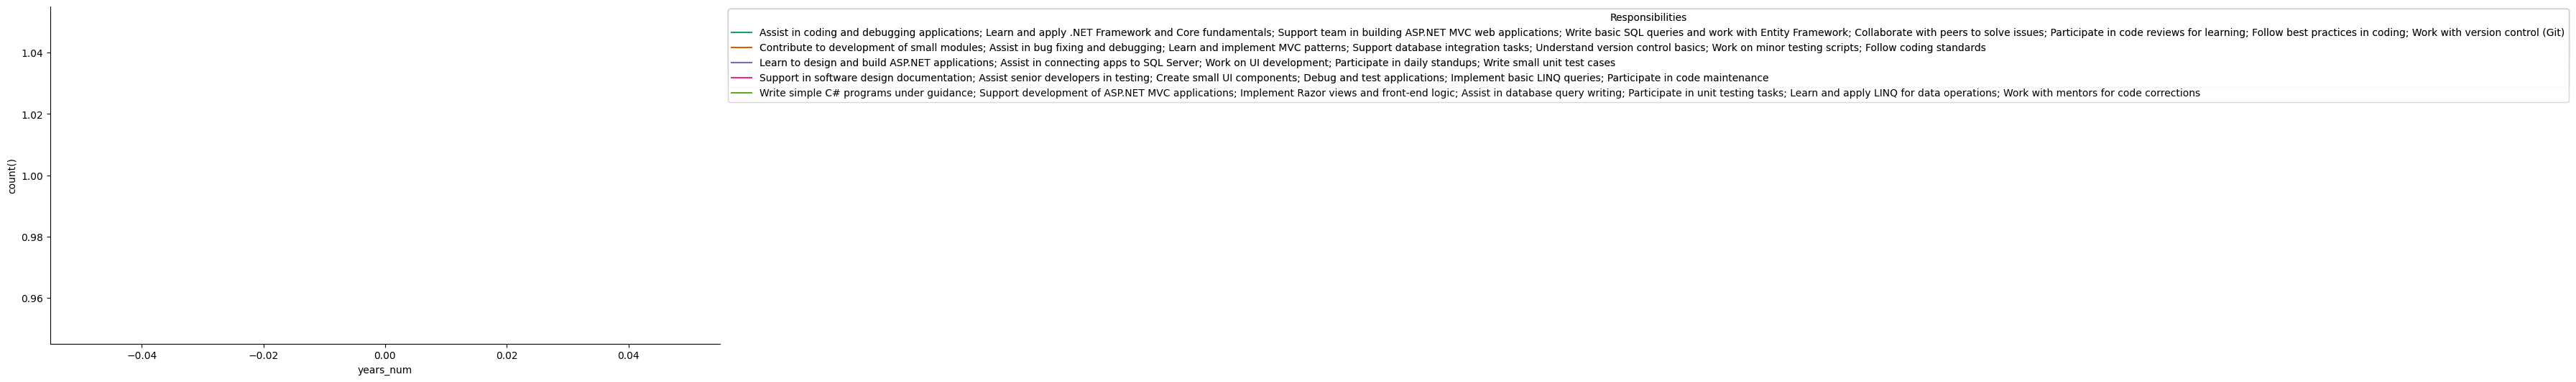

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['years_num']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'years_num'}, axis=1)
              .sort_values('years_num', ascending=True))
  xs = counted['years_num']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('years_num', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Responsibilities')):
  _plot_series(series, series_name, i)
  fig.legend(title='Responsibilities', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('years_num')
_ = plt.ylabel('count()')

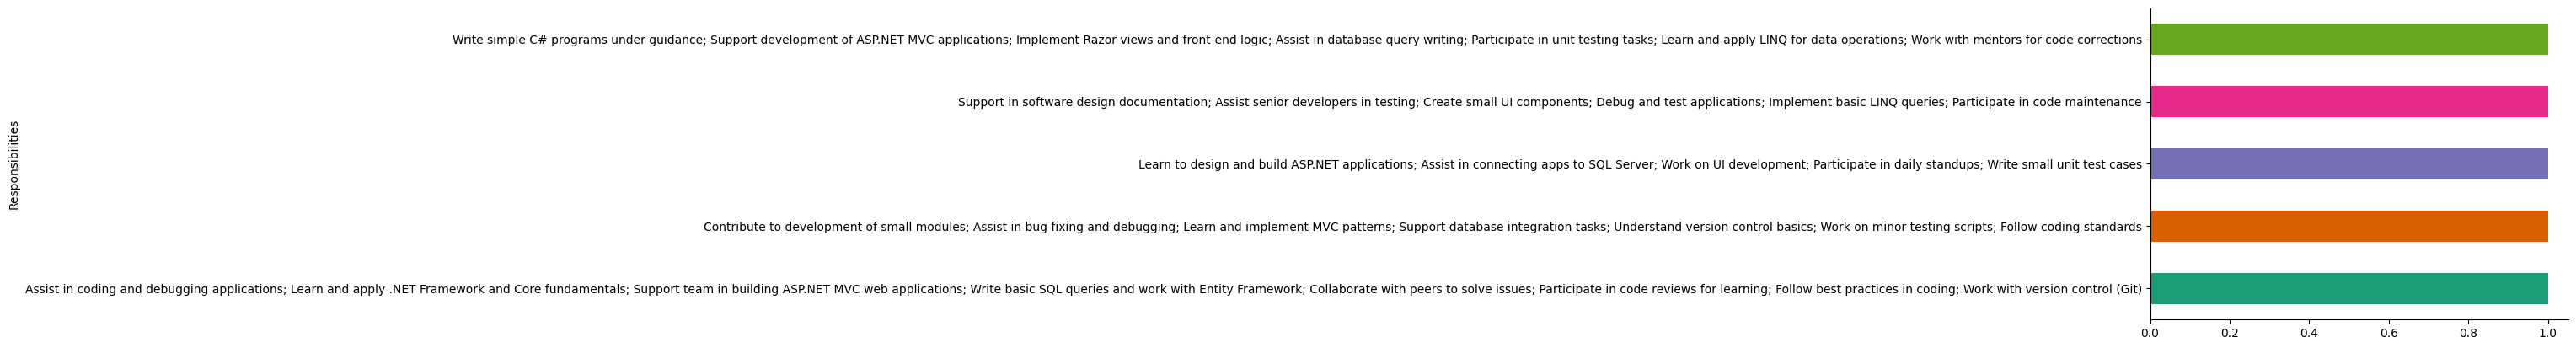

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Responsibilities').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

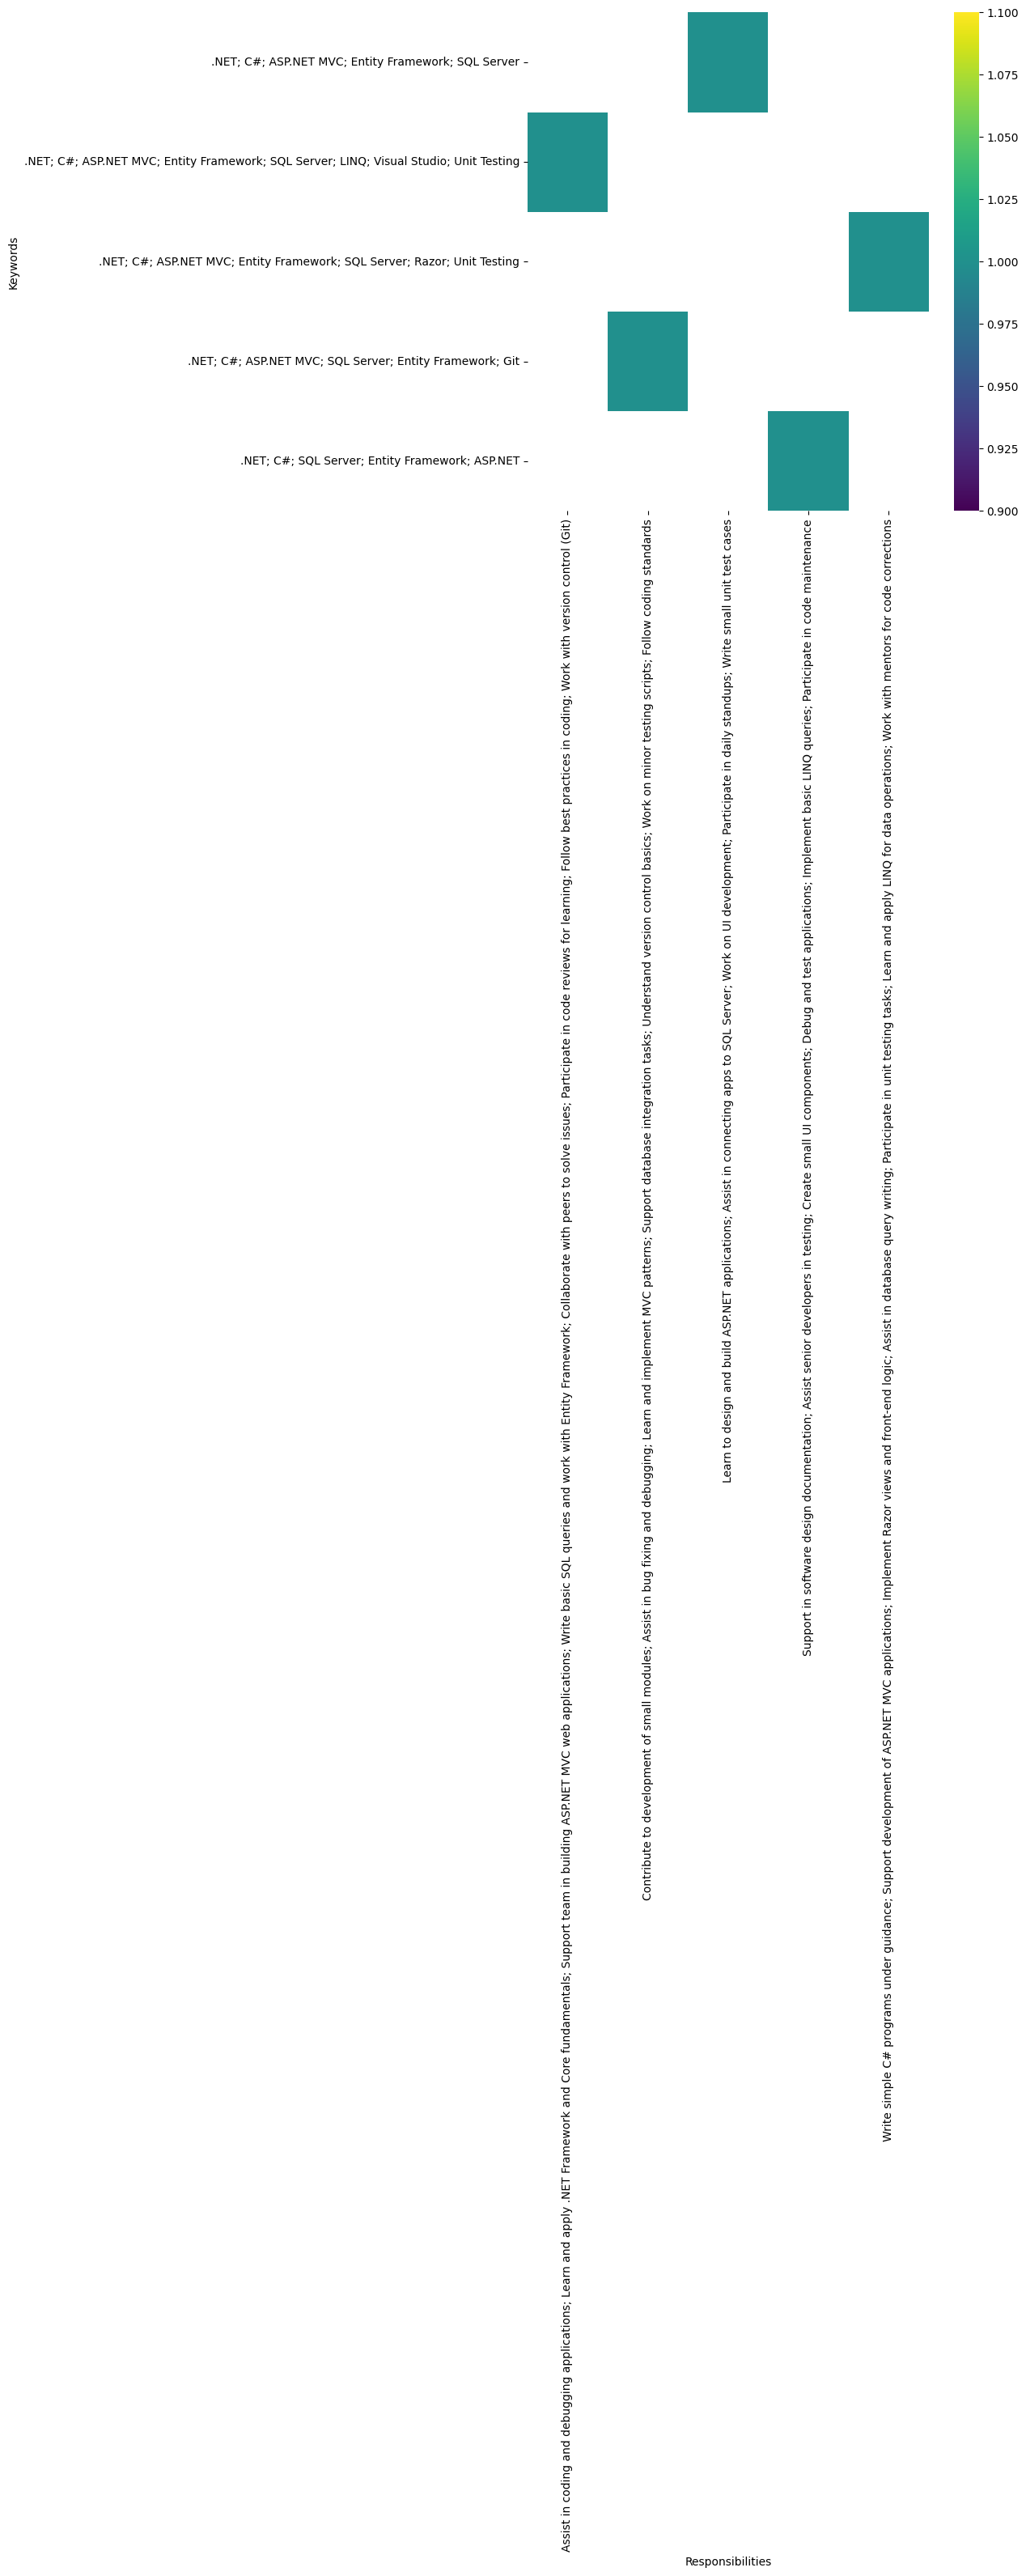

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Keywords'].value_counts()
    for x_label, grp in _df_10.groupby('Responsibilities')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Responsibilities')
_ = plt.ylabel('Keywords')

In [ ]:
# Assuming df, tfidf, and feature_names are defined from previous cells
# If not, the necessary data loading and preprocessing steps would need to be included here.

# Select a sample document (e.g., the first document in the DataFrame)
sample_document_index = 0
sample_text = df['text'].iloc[sample_document_index]

# Get the TF-IDF vector for the sample document
sample_tfidf_vector = X_text[sample_document_index]

# Get the feature names (words/ngrams)
feature_names = tfidf.get_feature_names_out()

# Find the TF-IDF values for some sample features in the document
# Let's pick a few features that might be present in the document
sample_features_to_check = ['developer', '.net', 'c#', 'basics', 'sql server', 'assist']

print(f"Sample Document (Index {sample_document_index}):")
print(sample_text)
print("\nTF-IDF values for selected features in this document:")

tfidf_values = {}
for feature in sample_features_to_check:
    try:
        # Get the index of the feature in the vocabulary
        feature_index = tfidf.vocabulary_[feature]
        # Get the TF-IDF value from the sparse vector
        tfidf_value = sample_tfidf_vector[0, feature_index]
        tfidf_values[feature] = tfidf_value
    except KeyError:
        tfidf_values[feature] = 0.0 # Feature not in vocabulary

# Print the TF-IDF values
for feature, value in tfidf_values.items():
    print(f"  '{feature}': {value:.4f}")

# You can also display a small part of the sparse matrix directly (less readable)
# print("\nPartial TF-IDF vector for sample document:")
# print(sample_tfidf_vector)

Sample Document (Index 0):
.NET Developer C#; VB.NET basics; .NET Framework; .NET Core fundamentals; ASP.NET; MVC; HTML; CSS; JavaScript basics; SQL Server; Entity Framework basics; LINQ; Visual Studio; Git; Unit Testing basics Assist in coding and debugging applications; Learn and apply .NET Framework and Core fundamentals; Support team in building ASP.NET MVC web applications; Write basic SQL queries and work with Entity Framework; Collaborate with peers to solve issues; Participate in code reviews for learning; Follow best practices in coding; Work with version control (Git) .NET; C#; ASP.NET MVC; Entity Framework; SQL Server; LINQ; Visual Studio; Unit Testing

TF-IDF values for selected features in this document:
  'developer': 0.0304
  '.net': 0.0000
  'c#': 0.0000
  'basics': 0.0995
  'sql server': 0.1319
  'assist': 0.0267


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.sparse import hstack, csr_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("job_dataset.csv")
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (1068, 7)
Columns: ['JobID', 'Title', 'ExperienceLevel', 'YearsOfExperience', 'Skills', 'Responsibilities', 'Keywords']


In [3]:
text_cols = []
for c in ['Title', 'Skills', 'Responsibilities', 'Keywords']:
    if c in df.columns:
        text_cols.append(df[c].fillna('').astype(str))
if not text_cols:
    raise ValueError("No text columns found; update text_cols list in code.")

df['text'] = text_cols[0]
for s in text_cols[1:]:
    df['text'] += '. ' + s


In [4]:
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')  # limit features for speed
X_tfidf = tfidf.fit_transform(df['text'])

In [6]:
# Create 'years_num' column by extracting numerical values from 'YearsOfExperience'
df['years_num'] = df['YearsOfExperience'].astype(str).str.extract(r'(\d+)').astype(float)

years_arr = np.array(df['years_num']).reshape(-1,1)
# scale the year feature
scaler_year = StandardScaler()
years_scaled = scaler_year.fit_transform(years_arr)

In [8]:
# Combine text features and scaled years feature
X = hstack([X_tfidf, years_scaled])

normalizer = Normalizer()      # row-normalize vectors
X_norm = normalizer.fit_transform(X)

In [9]:
pca = PCA(n_components=2, random_state=0)
X_vis = pca.fit_transform(X_norm.toarray() if hasattr(X_norm, "toarray") else X_norm)


In [10]:
def run_dbscan_and_metrics(eps, min_samples, metric='euclidean'):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, n_jobs=-1)
    labels = db.fit_predict(X_norm)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = int((labels == -1).sum())
    sil = np.nan
    dbi = np.nan
    if n_clusters > 1:
        try:
            sil = silhouette_score(X_norm, labels)
        except:
            sil = np.nan
        try:
            dbi = davies_bouldin_score(X_norm.toarray() if hasattr(X_norm, "toarray") else X_norm, labels)
        except:
            dbi = np.nan
    return {'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters,
            'n_noise': n_noise, 'silhouette': sil, 'dbi': dbi, 'labels': labels}

In [11]:
eps_values = np.arange(0.05, 1.05, 0.05)   # as requested in exercises
min_samples_list = [3, 5, 10, 20]
sweep_results = []

for m in min_samples_list:
    row_results = []
    for e in eps_values:
        res = run_dbscan_and_metrics(eps=round(e, 2), min_samples=m)
        row_results.append(res)
    sweep_results.append((m, row_results))


In [12]:
rows = []
for m, rr in sweep_results:
    for r in rr:
        rows.append({'min_samples': m, 'eps': r['eps'], 'n_clusters': r['n_clusters'],
                     'n_noise': r['n_noise'], 'silhouette': r['silhouette']})
summary_df = pd.DataFrame(rows)

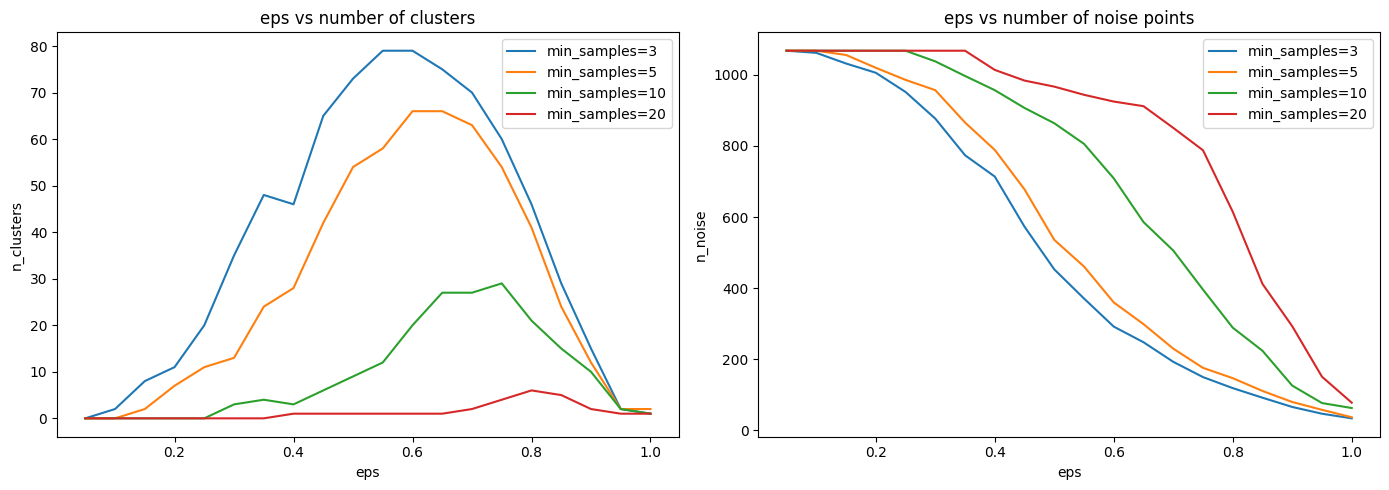

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
for m in min_samples_list:
    subset = summary_df[summary_df['min_samples']==m]
    plt.plot(subset['eps'], subset['n_clusters'], label=f'min_samples={m}')
plt.xlabel('eps')
plt.ylabel('n_clusters')
plt.title('eps vs number of clusters')
plt.legend()

plt.subplot(1,2,2)
for m in min_samples_list:
    subset = summary_df[summary_df['min_samples']==m]
    plt.plot(subset['eps'], subset['n_noise'], label=f'min_samples={m}')
plt.xlabel('eps')
plt.ylabel('n_noise')
plt.title('eps vs number of noise points')
plt.legend()
plt.tight_layout()
plt.show()

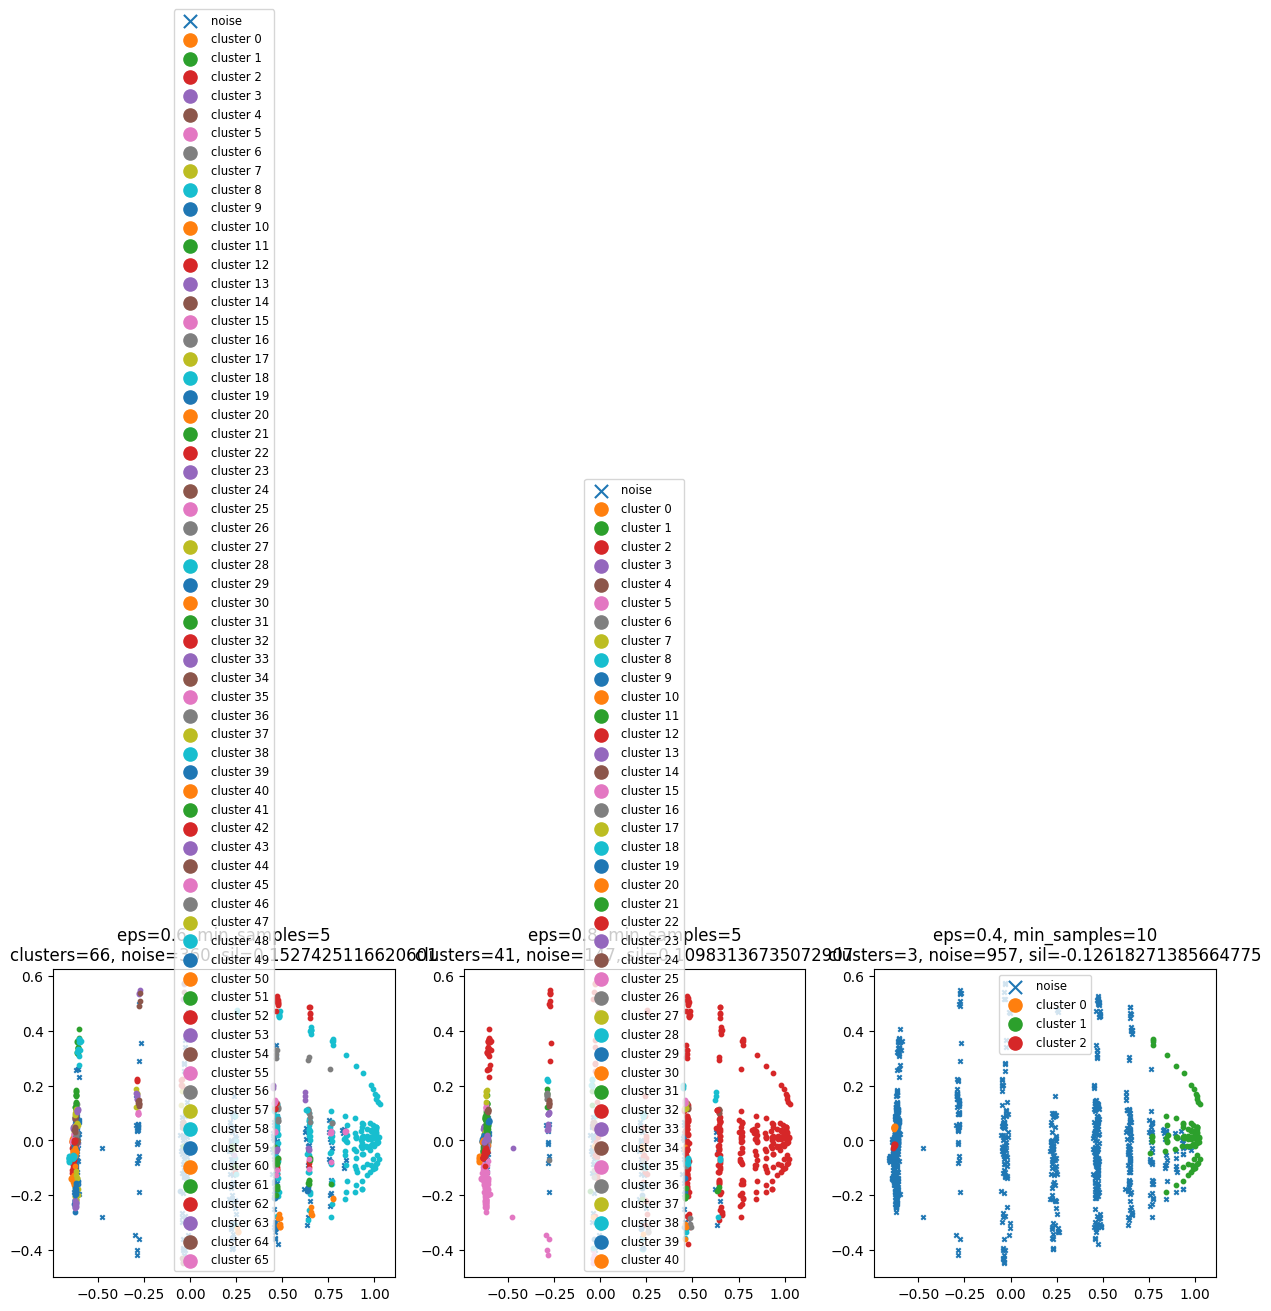

Saved sweep summary to dbscan_sweep_summary.csv


In [14]:
examples = [
    {'eps': 0.6, 'min_samples': 5},
    {'eps': 0.8, 'min_samples': 5},
    {'eps': 0.4, 'min_samples': 10},
]

fig, axes = plt.subplots(1, len(examples), figsize=(5*len(examples),4))
if len(examples)==1:
    axes = [axes]
for ax, p in zip(axes, examples):
    out = run_dbscan_and_metrics(eps=p['eps'], min_samples=p['min_samples'])
    labels = out['labels']
    unique_labels = sorted(set(labels))
    for k in unique_labels:
        mask = (labels == k)
        xy = X_vis[mask]
        if k == -1:
            ax.scatter(xy[:,0], xy[:,1], marker='x', s=10, label='noise')
        else:
            ax.scatter(xy[:,0], xy[:,1], s=10, label=f'cluster {k}')
    ax.set_title(f"eps={p['eps']}, min_samples={p['min_samples']}\nclusters={out['n_clusters']}, noise={out['n_noise']}, sil={out['silhouette']}")
    ax.legend(loc='best', markerscale=3, fontsize='small')
plt.tight_layout()
plt.show()

# ---------- 12. Save a summary CSV for your report ----------
summary_df.to_csv("dbscan_sweep_summary.csv", index=False)
print("Saved sweep summary to dbscan_sweep_summary.csv")

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming X and y are already defined from previous cells
# If not, you would need to include the data loading and preprocessing steps here.

# Split the data into training and testing sets (using an 80/20 split as in cell 4Cq6rP9k6D2Q)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("=== Support Vector Machine (SVM) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
# Assuming 'le' (LabelEncoder) is defined to get target names
# If not, you might need to fit a new LabelEncoder or manually define class names
try:
    print(classification_report(y_test, y_pred_svm, target_names=le.classes_))
except NameError:
    print("Could not find 'le' (LabelEncoder). Classification report target names may be missing.")
    print(classification_report(y_test, y_pred_svm))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

NameError: name 'y' is not defined

In [17]:
# Re-create df, X, y, and le
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataframe
df = pd.read_csv('job_dataset.csv')

# Re-create X and y
text_cols = ['Title', 'Skills', 'Responsibilities', 'Keywords']
for c in text_cols:
    if c not in df.columns:
        df[c] = ''
df[text_cols] = df[text_cols].fillna('')
df['text'] = (df['Title'].astype(str) + ' ' +
              df['Skills'].astype(str) + ' ' +
              df['Responsibilities'].astype(str) + ' ' +
              df['Keywords'].astype(str)).str.replace(r'\s+', ' ', regex=True)

# Re-create tfidf and X
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_text = tfidf.fit_transform(df['text'])
df['years_num'] = df['YearsOfExperience'].astype(str).str.extract(r'(\d+)').astype(float)
scaler = StandardScaler()
years_scaled = scaler.fit_transform(df[['years_num']].astype(float))
years_sparse = csr_matrix(years_scaled)
X = hstack([X_text, years_sparse])

# Re-create y and class_names
def map_explevel(s):
    s = str(s).lower()
    if any(x in s for x in ['fresher', 'intern', 'trainee']):
        return 'Fresher'
    if any(x in s for x in ['entry', 'junior', 'associate', 'entry-level']):
        return 'Entry'
    if any(x in s for x in ['mid', 'mid-senior', 'mid level', 'mid-senior level']):
        return 'Mid'
    if any(x in s for x in ['senior', 'lead', 'principal', 'manager', 'experienced', 'senior-level']):
        return 'Senior'
    nums = re.findall(r'\d+(?:\.\d+)?', s)
    if nums:
        nums = [float(n) for n in nums]
        avg = sum(nums)/len(nums)
        if avg <= 1: return 'Fresher'
        if avg <= 3: return 'Entry'
        if avg <= 6: return 'Mid'
        return 'Senior'
    return 'Other'

df['label'] = df['ExperienceLevel'].apply(map_explevel)
df = df[df['label'] != 'Other'].copy()

le = LabelEncoder()
y = le.fit_transform(df['label'])

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming X and y are already defined from previous cells (e.g., cell e0b5d5de)
# If not, you would need to include the data loading and preprocessing steps here.

# Split the data into training and testing sets (using an 80/20 split as in cell 4Cq6rP9k6D2Q)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)


xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n=== XGBoost Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
# Assuming 'le' (LabelEncoder) is defined to get target names if needed for classification_report
# If not, you might need to fit a new LabelEncoder or manually define class names
try:
    print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))
except NameError:
    print("Could not find 'le' (LabelEncoder). Classification report target names may be missing.")
    print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


=== XGBoost Classifier ===
Accuracy: 0.9766355140186916
              precision    recall  f1-score   support

       Entry       1.00      1.00      1.00        14
     Fresher       1.00      1.00      1.00        73
         Mid       1.00      0.64      0.78        14
      Senior       0.96      1.00      0.98       113

    accuracy                           0.98       214
   macro avg       0.99      0.91      0.94       214
weighted avg       0.98      0.98      0.97       214

Confusion Matrix:
 [[ 14   0   0   0]
 [  0  73   0   0]
 [  0   0   9   5]
 [  0   0   0 113]]


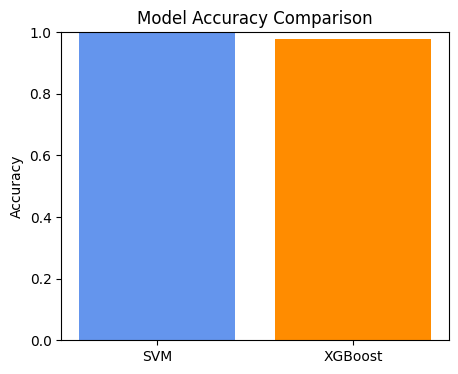

In [21]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC # Import SVC
from xgboost import XGBClassifier # Import XGBClassifier

# Assuming X and y are already defined from previous cells (e.g., cell e0b5d5de)
# If not, you would need to include the data loading and preprocessing steps here.

# Split the data into training and testing sets (using an 80/20 split as in cell 4Cq6rP9k6D2Q)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Train and predict with SVM model (code moved from DRpDi3ptNYly)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Assuming y_pred_xgb is defined from a previous cell (A3QR9H5iNn9z)
# If not, you would need to include the XGBoost training and prediction here as well.

models = ['SVM', 'XGBoost']
accuracies = [
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_xgb)
]

plt.figure(figsize=(5,4))
plt.bar(models, accuracies, color=['cornflowerblue','darkorange'])
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time

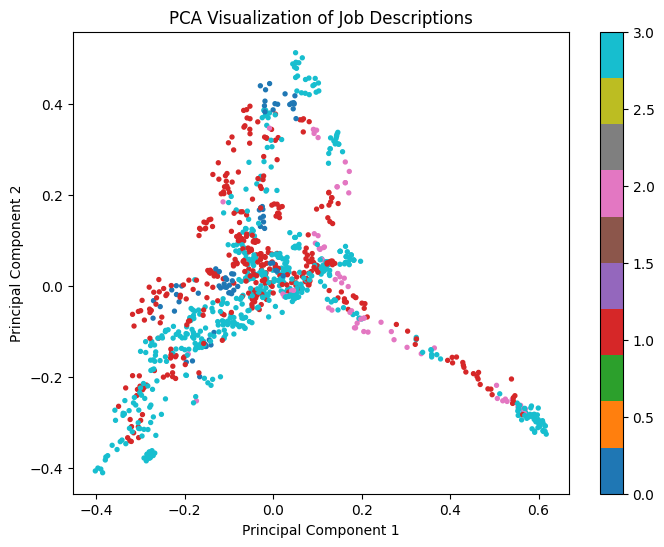

In [23]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='tab10', s=8)
plt.colorbar(scatter)
plt.title("PCA Visualization of Job Descriptions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


t-SNE completed in 19.08s


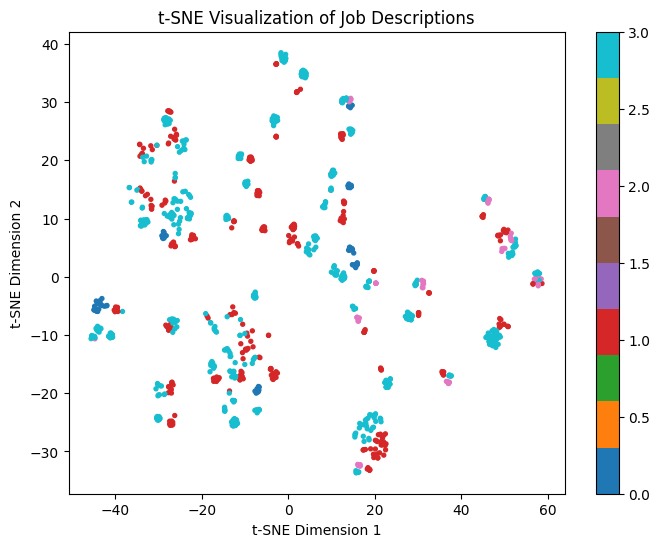

In [24]:
start = time.time()
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())
print(f"t-SNE completed in {time.time()-start:.2f}s")

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='tab10', s=8)
plt.colorbar(scatter)
plt.title("t-SNE Visualization of Job Descriptions")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

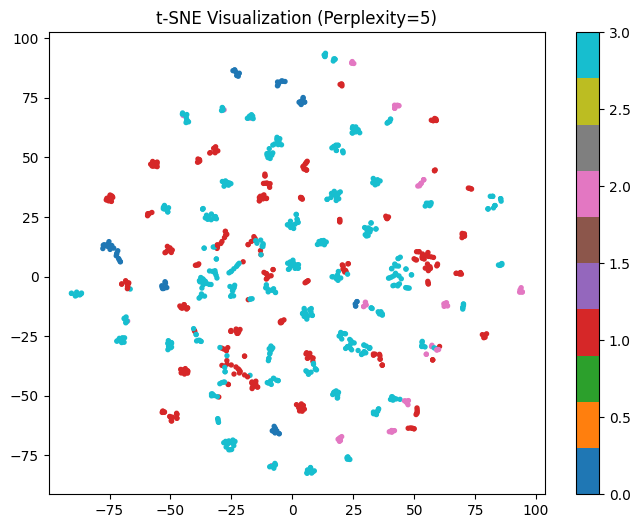

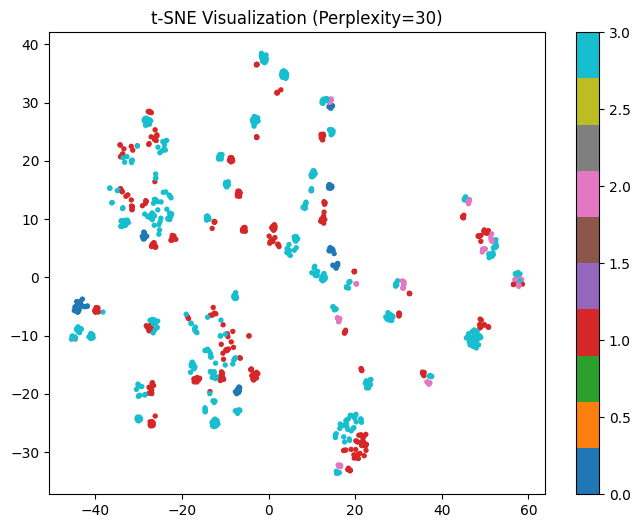

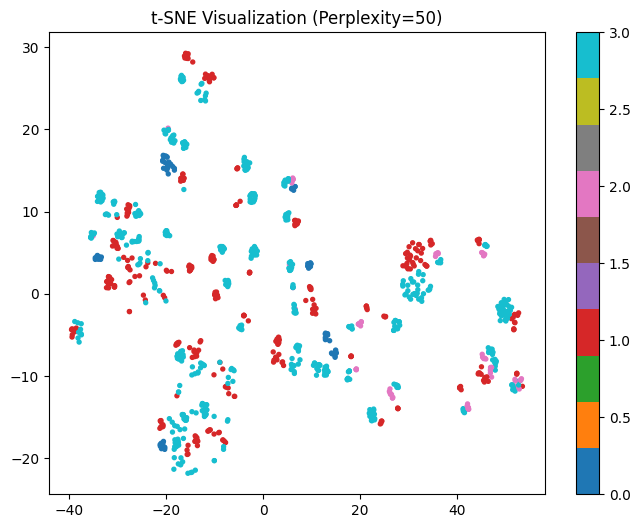

In [25]:
for perp in [5, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=perp, n_iter=1000, random_state=42)
    X_emb = tsne.fit_transform(X_tfidf.toarray())
    plt.figure(figsize=(8,6))
    sc = plt.scatter(X_emb[:,0], X_emb[:,1], c=y, cmap='tab10', s=8)
    plt.colorbar(sc)
    plt.title(f"t-SNE Visualization (Perplexity={perp})")
    plt.show()